In [1]:
# The numerical integrators are located in a module two levels above
# the current working directory. Hence:
import sys
sys.path.insert(0, '../..')

# Package imports

In [2]:
import matplotlib as mpl

mpl.use("pgf")

## TeX preamble
preamble = [
    r'\usepackage{fontspec}',
    r'\setmainfont{Linux Libertine O}',
]

params = {
    'font.family': 'serif',
    'text.usetex': True,
    'text.latex.unicode': True,
    'pgf.rcfonts': False,
    'pgf.texsystem': 'xelatex',
    'pgf.preamble': preamble,
}

mpl.rcParams.update(params)

In [3]:
# Numpy
import numpy as np

# Matplotlib
from matplotlib import pyplot as plt
plt.rc('text',usetex=True)
plt.rc('figure',figsize=(18,10),dpi=100)
%matplotlib inline

# Numba (JiT)
from numba import njit

# (Primitive) timing functionality
import time 

# Multiprocessing:
import multiprocessing as mp

# Spline interpolation:
from scipy.interpolate import RectBivariateSpline

# Check whether folders exist or not, necessary
# for storing advected states:
import os
import errno

# Display progress bars:
from ipywidgets import FloatProgress
from IPython.display import display

# Function that creates directories if they don't exist

In [4]:
# Function that makes a directory if it does not exist,
# and raises an exception otherwise 
# (necessary for storing advected states)

def ensure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

# Set of implemented fixed step integrators
## Important for saving/loading states

In [5]:
fixed_step_integrators = set(['euler','rk2','rk3','rk4'])

# Function that generates an extended grid of tracers

In [6]:
def padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max):
    x_0,dx = np.linspace(x_min,x_max,nx,retstep=True)
    y_0,dy = np.linspace(y_min,y_max,ny,retstep=True)
    
    x = np.empty(nx+4)
    x[0:2] = -2*dx, -dx
    x[2:-2] = x_0
    x[-2:] = x_max+dx, x_max+2*dx
    
    y = np.empty(ny+4)
    y[0:2] = -2*dy, -dy
    y[2:-2] = y_0
    y[-2:] = y_max+dy, y_max+2*dy
    
    nx_ = nx+4
    ny_ = ny+4
    
    grid = np.empty((2,nx_*ny_))
    
    for j in range(nx_):
        grid[0,j*ny_:(j+1)*ny_] = x[j]
        grid[1,j*ny_:(j+1)*ny_] = y
    
    return grid   

# Function which calculates characteristics

In [7]:
def characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,integrator,stride,n_proc=4,atol=None,rtol=None):
    if atol is None:
        atol = 1.e-9
    if rtol is None:
        rtol = 1.e-9
    
    grid = padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max)
    dx_main = (x_max-x_min)/(nx-1)
    dy_main = (y_max-y_min)/(ny-1)
    
    dx_aux = np.minimum(1e-5,dx_main*1e-2)
    dy_aux = np.minimum(1e-5,dy_main*1e-2)
    
    lmbd1,lmbd2,hess_lmbd2,xi1,xi2 = _characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,dx_main,dy_main,dx_aux,dy_aux,integrator,stride,n_proc,atol,rtol)
    
    return grid,lmbd1,lmbd2,hess_lmbd2,xi1,xi2

def _characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,dx_main,dy_main,dx_aux,dy_aux,integrator,stride,n_proc,atol,rtol):
    if integrator.__name__ in fixed_step_integrators:
        try:
            grid = np.load('precomputed_advection/{}/advected_grid_Nx={}_Ny={}_dx_main={}_dy_main={}_dx_aux={}_dy_aux={}_t_start={}_t_end={}_h={}.npy'.format(integrator.__name__,nx,ny,dx_main,dy_main,dx_aux,dy_aux,t_start,t_end,stride))
            print('Precomputed advection found! Advection not necessary!')
        except IOError:
            print('Precomputed advection not found!')
    else:
        try:
            grid = np.load('precomputed_advection/{}/advected_grid_Nx={}_Ny={}_dx_main={}_dy_main={}_dx_aux={}_dy_aux={}_t_start={}_t_end={}_atol={}_rtol={}.npy'.format(integrator.__name__,nx,ny,dx_main,dy_main,dx_aux,dy_aux,t_start,t_end,atol,rtol))
            print('Precomputed advection found! Advection not necessary!')
        except IOError:
            print('Precomputed advection not found!')
    
    tic = time.time()                              
    
    tens_main,tens_aux = _find_strain_tensors(grid,nx,ny,dx_main,dy_main,dx_aux,dy_aux)
    
    lmbd1,lmbd2,xi1,xi2 = _find_characteristics(tens_main,tens_aux)
    
    hess_lmbd2 = _find_hessian(lmbd2,nx,ny,dx_main,dy_main)
                
    mins,secs = np.divmod(time.time()-tic,60)
    
    print('Characteristics calculated in {} minutes and {} seconds'.format(mins,secs))        
    
    return lmbd1,lmbd2,hess_lmbd2,xi1,xi2

def _find_strain_tensors(grid,nx,ny,dx_main,dy_main,dx_aux,dy_aux):
    grid_main = grid[0].reshape((2,nx+4,ny+4))
    grid_right = grid[1].reshape((2,nx+4,ny+4))
    grid_top = grid[2].reshape((2,nx+4,ny+4))
    grid_left = grid[3].reshape((2,nx+4,ny+4))
    grid_btm = grid[4].reshape((2,nx+4,ny+4))
    
    # Declare Jacobians
    df_m = np.empty((nx+4,ny+4,2,2))
    df_a = np.empty((nx+4,ny+4,2,2))
    
    # Use centered differencing throughout for auxiliary Jacobian:
    df_a[:,:,0,0] = (grid_right[0]-grid_left[0])/(2*dx_aux)
    df_a[:,:,0,1] = (grid_top[0]-grid_btm[0])/(2*dy_aux)
    df_a[:,:,1,0] = (grid_right[1]-grid_left[1])/(2*dx_aux)
    df_a[:,:,1,1] = (grid_top[1]-grid_btm[1])/(2*dy_aux)
    
    # Use centered differencing where applicable for main Jacobian,
    # second order backwards/forwards difference otherwise
    df_m[1:-1,:,0,0] = (grid_main[0,2:,:]-grid_main[0,0:-2,:])/(2*dx_main)
    df_m[0,:,0,0] = (-3*grid_main[0,0,:]+4*grid_main[0,1,:]-2*grid_main[0,2,:])/(2*dx_main)
    df_m[-1,:,0,0] = (3*grid_main[0,-1,:]-4*grid_main[0,-2,:]+2*grid_main[0,-3,:])/(2*dx_main)
    
    df_m[:,1:-1,0,1] = (grid_main[0,:,2:]-grid_main[0,:,0:-2])/(2*dy_main)
    df_m[:,0,0,1] = (-3*grid_main[0,:,0]+4*grid_main[0,:,1]-2*grid_main[0,:,2])/(2*dy_main)
    df_m[:,-1,0,1] = (3*grid_main[0,:,-1]-4*grid_main[0,:,-2]+2*grid_main[0,:,-3])/(2*dy_main)
    
    df_m[1:-1,:,1,0] = (grid_main[1,2:,:]-grid_main[1,0:-2,:])/(2*dx_main)
    df_m[0,:,1,0] = (-3*grid_main[1,0,:]+4*grid_main[1,1,:]-2*grid_main[1,2,:])/(2*dx_main)
    df_m[-1,:,1,0] = (3*grid_main[1,-1,:]-4*grid_main[1,-2,:]+2*grid_main[1,-3,:])/(2*dx_main)
    
    df_m[:,1:-1,1,1] = (grid_main[1,:,2:]-grid_main[1,:,0:-2])/(2*dy_main)
    df_m[:,0,1,1] = (-3*grid_main[1,:,0]+4*grid_main[1,:,1]-2*grid_main[1,:,2])/(2*dy_main)
    df_m[:,-1,1,1] = (3*grid_main[1,:,-1]-4*grid_main[1,:,-2]+2*grid_main[1,:,-3])/(2*dy_main)
    
    # Reshape Jacobian arrays:
    df_a = df_a.reshape(((nx+4)*(ny+4),2,2))
    df_m = df_m.reshape(((nx+4)*(ny+4),2,2))
    
    # Calculate strain tensors:
    c_m = np.matmul(np.transpose(df_m,axes=(0,2,1)),df_m)
    c_a = np.matmul(np.transpose(df_a,axes=(0,2,1)),df_a)
        
    return c_m,c_a

def _find_characteristics(tens_main,tens_aux):
    
    vals = np.linalg.eigvalsh(tens_main)
    bar, vecs = np.linalg.eigh(tens_aux)
    
    lmbd1 = vals[:,0]
    lmbd2 = vals[:,1]
    
    xi1 = vecs[:,:,0]
    xi2 = vecs[:,:,1]
    
    return lmbd1,lmbd2,xi1,xi2

def _find_hessian(lmbd_,nx,ny,dx_main,dy_main):
    lmbd = lmbd_.reshape((nx+4,ny+4))
    
    hessian = np.empty((nx+4,ny+4,2,2))
    
    # First, the laplacian terms:
    
    # Internal points: Centered differences
    hessian[1:-1,:,0,0] = (lmbd[2:,:]-2*lmbd[1:-1,:]+lmbd[:-2,:])/(dx_main**2)
    hessian[:,1:-1,1,1] = (lmbd[:,2:]-2*lmbd[:,1:-1]+lmbd[:,:-2])/(dy_main**2)
    
    # Near boundaries: Higher order forwards/backwards differences
    hessian[0,:,0,0] = (2*lmbd[0,:]-5*lmbd[1,:]+4*lmbd[2,:]-lmbd[3,:])/(dx_main**2)
    hessian[-1,:,0,0] = (2*lmbd[-1,:]-5*lmbd[-2,:]+4*lmbd[-3,:]-lmbd[-4,:])/(dx_main**2)
    
    hessian[:,0,1,1] = (2*lmbd[:,0]-5*lmbd[:,1]+4*lmbd[:,2]-lmbd[:,3])/(dy_main**2)
    hessian[:,-1,1,1] = (2*lmbd[:,-1]-5*lmbd[:,-2]+4*lmbd[:,-3]-lmbd[:,-4])/(dy_main**2)
    
    # Then, the mixed derivatives:
    dldx = np.empty((nx+4,ny+4))
    dldy = np.empty((nx+4,ny+4))
    
    # Internal points: Centered differences
    dldx[1:-1,:] = (lmbd[2:,:]-lmbd[:-2,:])/(2*dx_main)
    dldy[:,1:-1] = (lmbd[:,2:]-lmbd[:,:-2])/(2*dy_main)
    
    # Near boundaries: Higher order forwards/backwards differences
    dldx[0,:] = (-3*lmbd[0,:]+4*lmbd[1,:]-lmbd[2,:])/(2*dx_main)
    dldx[-1,:] = (3*lmbd[-1,:]-4*lmbd[-2,:]+lmbd[-3,:])/(2*dx_main)
    
    dldy[:,0] = (-3*lmbd[:,0]+4*lmbd[:,1]-lmbd[:,2])/(2*dy_main)
    dldy[:,-1] = (3*lmbd[:,-1]-4*lmbd[:,-2]+lmbd[:,-3])/(2*dy_main)
    
    # Same deal for the mixed derivatives
    d2ldxdy = np.empty((nx+4,ny+4))
    d2ldydx = np.empty((nx+4,ny+4))
    
    # Internal points: Centered differences
    d2ldxdy[1:-1,:] = (dldy[2:,:]-dldy[:-2,:])/(2*dx_main)
    d2ldydx[:,1:-1] = (dldx[:,2:]-dldx[:,:-2])/(2*dy_main)
    
    # Near boundaries: Higher order forwards/backwards differences
    d2ldxdy[0,:] = (-3*dldy[0,:]+4*dldy[1,:]-dldy[2,:])/(2*dx_main)
    d2ldxdy[-1,:] = (3*dldy[-1,:]-4*dldy[-2,:]+dldy[3,:])/(2*dx_main)
    
    d2ldydx[:,0] = (-3*dldx[:,0]+4*dldx[:,1]-dldx[:,2])/(2*dy_main)
    d2ldydx[:,-1] = (3*dldx[:,-1]-4*dldx[:,-2]+dldx[:,-3])/(2*dy_main)
    
    hessian[:,:,0,1] = d2ldxdy
    hessian[:,:,1,0] = d2ldydx
    
    return hessian.reshape((nx+4)*(ny+4),2,2)
    

# Define transport parameters

In [20]:
from numerical_integrators.adaptive_step import rkbs32,rkbs54,rkdp54,rkdp87
from numerical_integrators.singlestep import euler,rk2,rk3,rk4
t_start = 0.
t_end = 20.
h = 0.1

atol = 1e-10
rtol = atol

integrator=rkbs54

x_min,x_max = 0,2
y_min,y_max = 0,1

nx,ny = 1000,500

# Load advected state

In [21]:
grid_,lmbd1_,lmbd2_,hess_lmbd2_,xi1_,xi2_ = characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,integrator,h,atol=atol,rtol=rtol)

_inner_mask = np.zeros((nx+4,ny+4),dtype=np.bool)
_inner_mask[2:-2,2:-2] = True
_inner_mask = _inner_mask.reshape((nx+4)*(ny+4))

grid = grid_[:,_inner_mask]
x_ = grid_[0,::ny+4]
y_ = grid_[1,:ny+4]
x = x_[2:-2]
y = y_[2:-2]
lmbd1 = lmbd1_[_inner_mask]
lmbd2 = lmbd2_[_inner_mask]
hess_lmbd2 = hess_lmbd2_[_inner_mask,:,:]
xi1 = xi1_[_inner_mask,:]
xi2 = xi2_[_inner_mask,:]

Precomputed advection found! Advection not necessary!
Characteristics calculated in 0.0 minutes and 3.1464169025421143 seconds


# Functions identifying $\mathcal{U}_{0}$ domain

In [10]:
def find_ab_mask(lmbd1,lmbd2,hess_lmbd2,xi2):
    return np.logical_and(_a_true(lmbd1,lmbd2),_b_true(hess_lmbd2,xi2))

def _a_true(lmbd1,lmbd2):
    return np.logical_and(np.less(lmbd1,lmbd2),np.greater(lmbd2,1))

def _b_true(hess_lmbd2,xi2):
    #tf = np.zeros(hess_lmbd2.shape[0],dtype=np.bool)
    #for j in range(len(tf)):
    #    if np.dot(xi2[j],np.dot(hess_lmbd2[j],xi2[j])) <=0:
    #        tf[j] = True
    #return tf
    return np.less_equal(np.sum(xi2*np.sum(hess_lmbd2*xi2[...,np.newaxis],axis=1),axis=1),0)

# Find $\mathcal{U}_{0}$ domain

In [23]:
mask_ab = find_ab_mask(lmbd1,lmbd2,hess_lmbd2,xi2)

# Plot $\mathcal{U}_{0}$ domain

(0, 1)

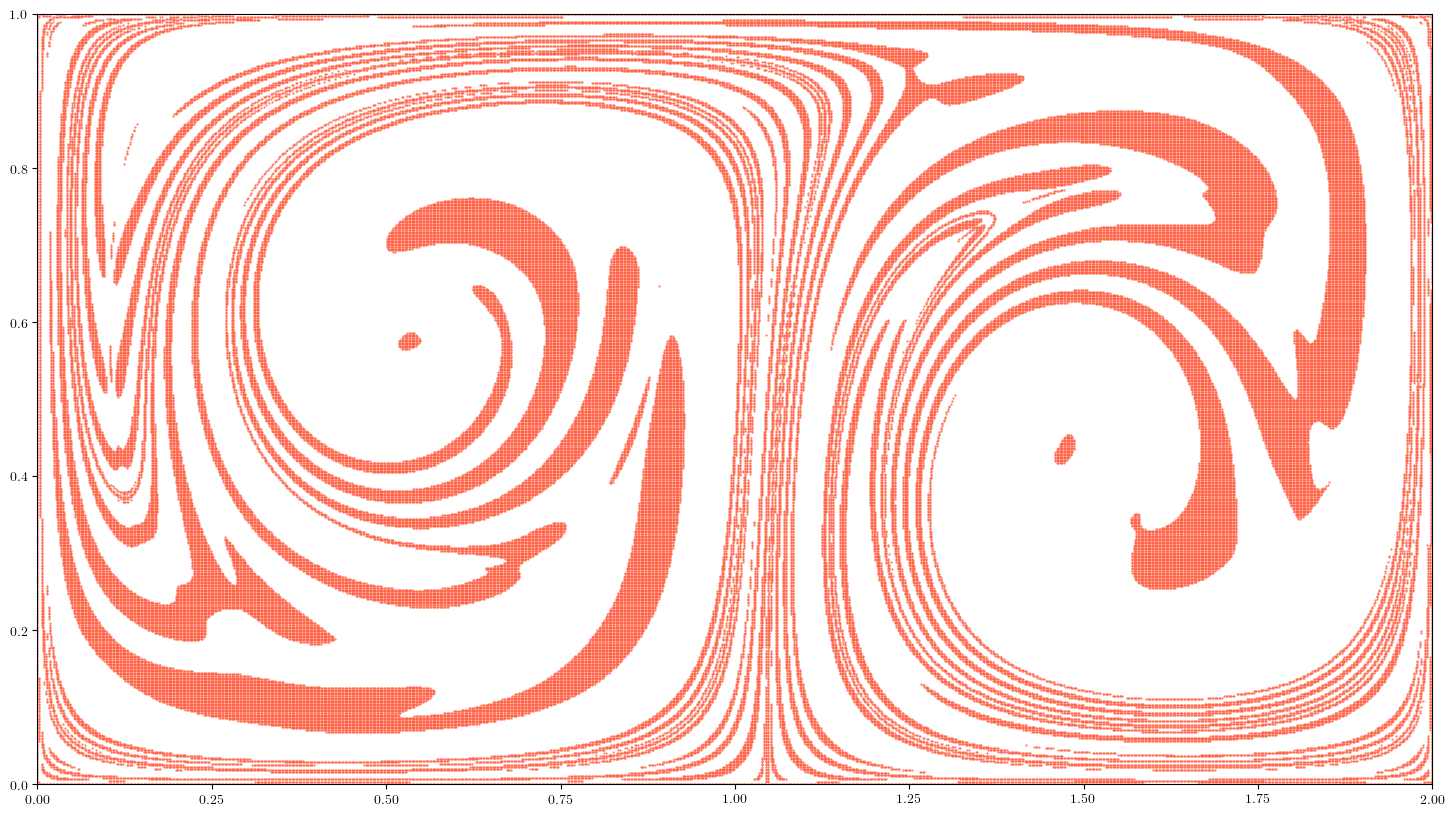

In [24]:
plt.figure()
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],s=1,marker='.',c='tomato')
plt.xlim(0,2)
plt.ylim(0,1)

# Function that finds $\mathcal{G}_{0}$

In [13]:
def find_g0(nx,ny,num_horz,num_vert):
    mask = np.zeros((nx,ny),dtype=bool)
    stride_horz = np.floor(nx/(num_horz+1)).astype(int)
    stride_vert = np.floor(ny/(num_vert+1)).astype(int)
    
    for j in range(1,num_vert+1):
        mask[np.minimum(j*stride_horz,nx-1),:] = True
    for j in range(1,num_horz+1):
        mask[:,np.minimum(j*stride_vert,ny-1)] = True
    
    mask = mask.reshape(nx*ny)
    
    return mask

# Choose no. of vert. and horz. lines in $\mathcal{G}_{0}$, and find it

In [14]:
num_horz_g0 = 4
num_vert_g0 = 4
g0 = grid[:,np.logical_and(find_g0(nx,ny,num_horz_g0,num_vert_g0),mask_ab)]

# Plot $\mathcal{G}_{0}$

(0, 1)

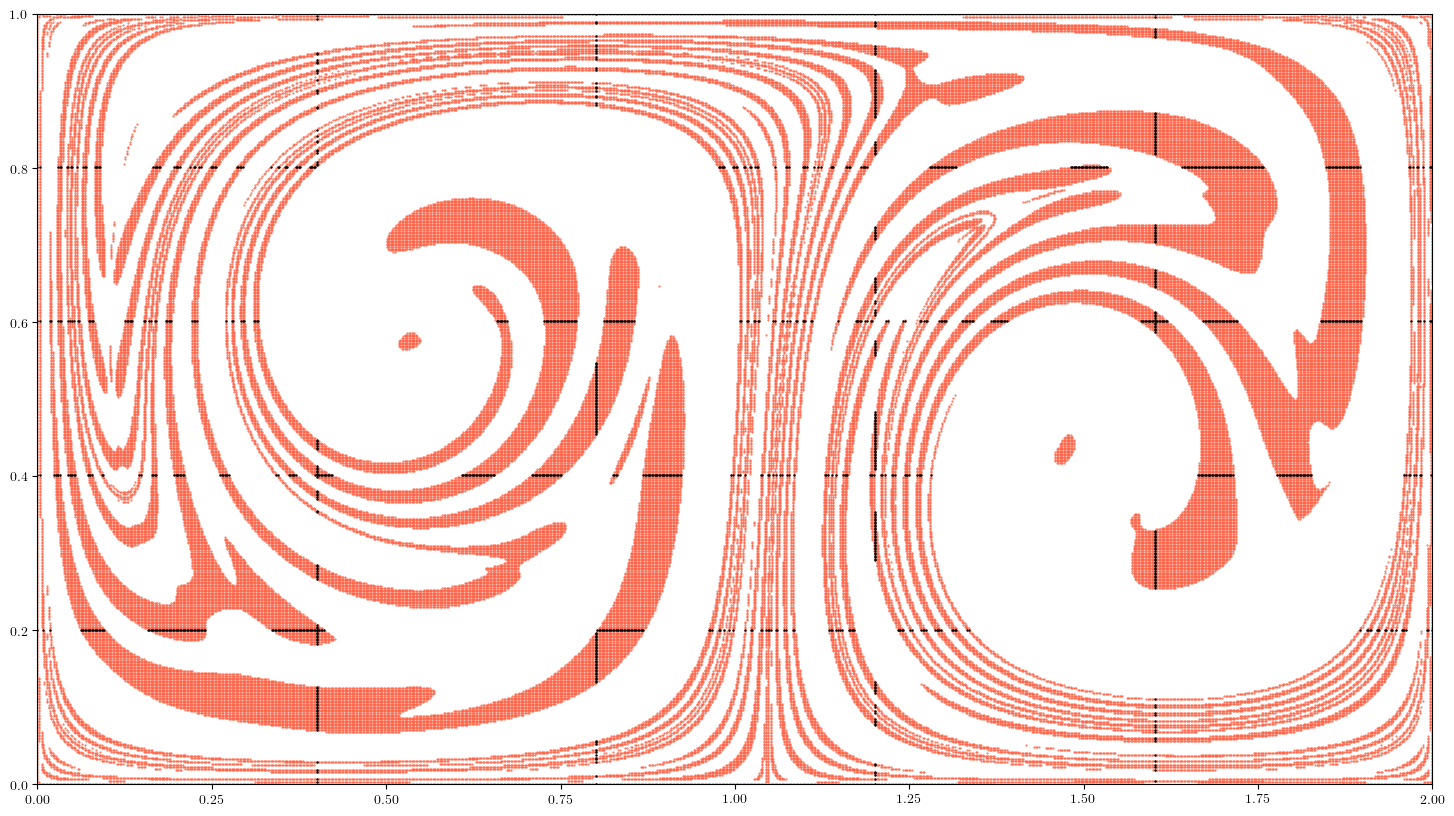

In [15]:
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],marker='.',s=1,c='tomato')
plt.scatter(g0[0],g0[1],marker='.',s=2,c='k')
plt.xlim(0,2)
plt.ylim(0,1)

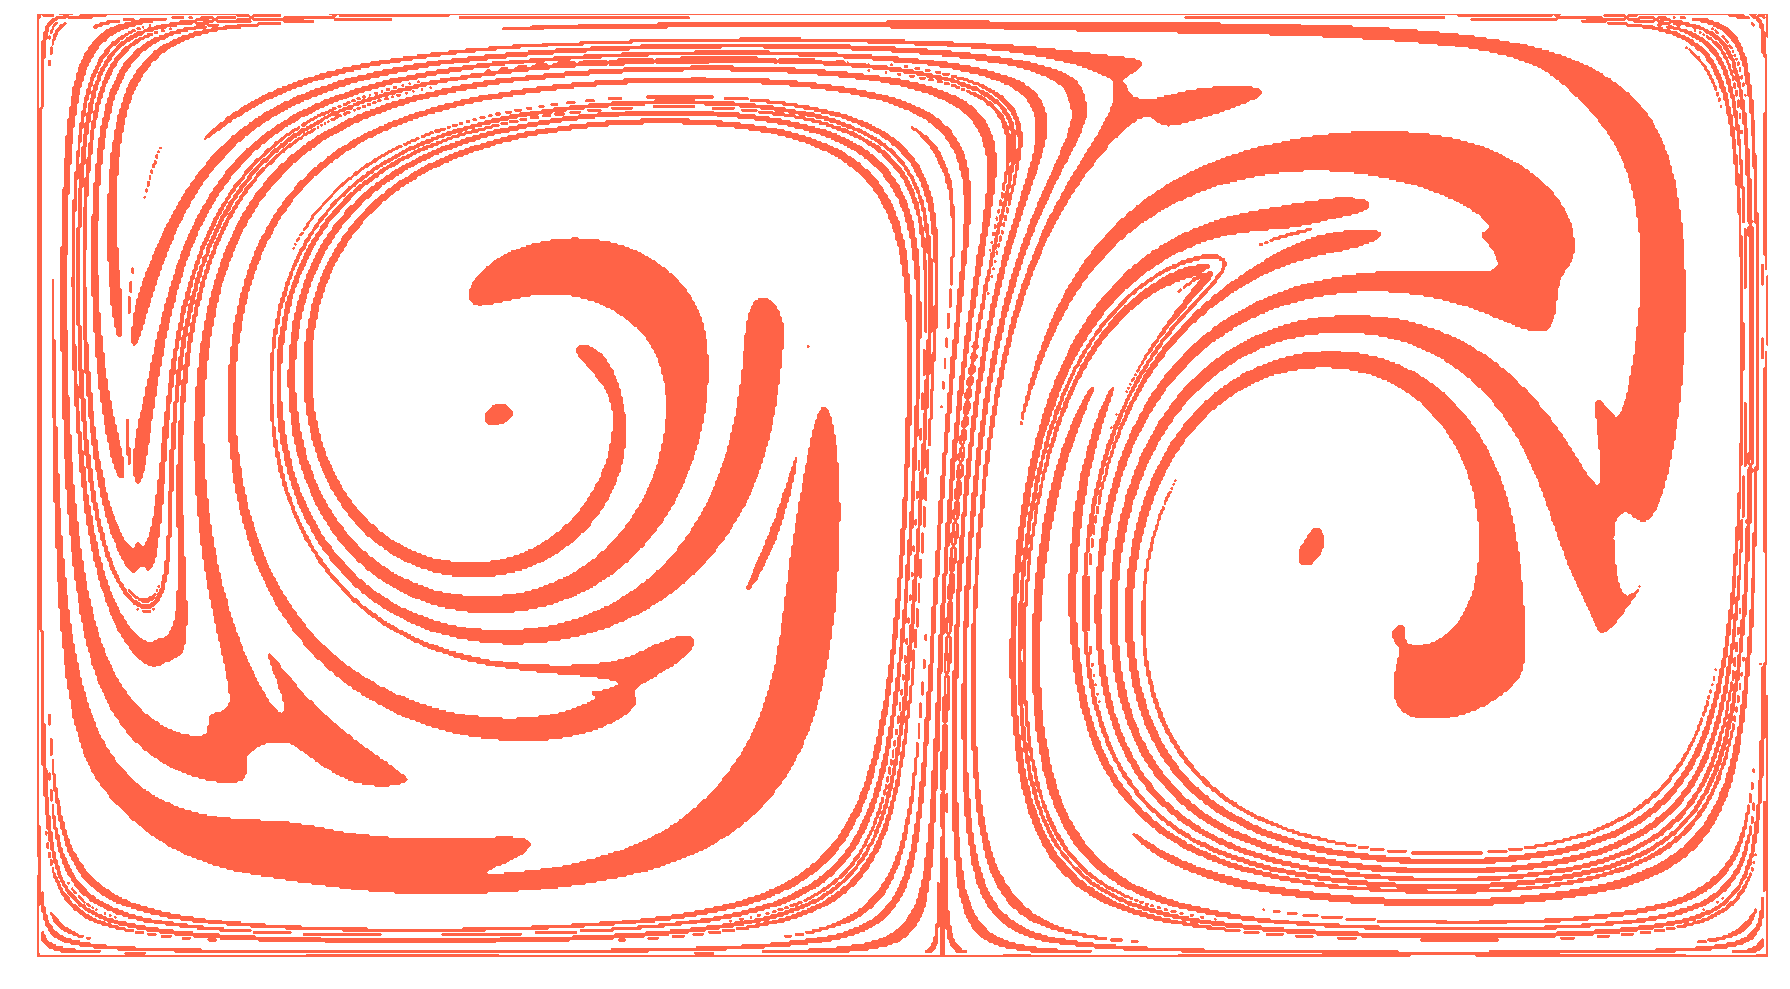

In [25]:
fig = plt.figure(1)
plot = fig.add_subplot(111)

cm = mpl.colors.ListedColormap(['white','tomato'])

plot.contourf(grid.reshape(2,nx,ny)[0,:,0],grid.reshape(2,nx,ny)[1,0,:],mask_ab.reshape(nx,ny).T,cmap=cm)
#plt.scatter(g0[0],g0[1],c='k',s=1,marker='.')
#plot.tick_params(axis='both', which='major', labelsize=20)
#plot.tick_params(axis='both', which='minor', labelsize=10)
plt.axis('off')
#plot.set_xlim(0,2)
#plot.set_ylim(0,1)
plt.tight_layout()
plt.savefig('/home/arne/Desktop/AB_red.png',dpi=100)


# Definition of the Strainline class

In [ ]:
class Strainline:
    def __init__(self,startpoint,l_min,l_f_max,lmbd2_spline):
        self.pos = np.array([startpoint]).reshape((2,1))
        self.l_min = l_min
        self.lmbd2_spline = lmbd2_spline
        self.stationary = np.zeros(2,dtype=np.bool)
        self.cont_failure = np.zeros(2,dtype=np.bool)
        self.outs_dom = np.zeros(2,dtype=np.bool)
        self.max_iter = np.zeros(2,dtype=np.bool)
        self.startpoint_index = 0
        self.tailcut_start = 0
        self.tailcut_end = 0
    def long_enough(self):
        return self.len >= self.l_min
    def append(self,pos):
        self.pos = np.hstack((self.pos,pos.reshape((2,1))))
    def traj(self):
        return self.pos
    def avg_lmbd2(self):
        return np.mean(self.lmbd2_spline.ev(self.pos[1],self.pos[0]))
    def lngth(self):
        return np.sum(np.sqrt((np.diff(self.pos,axis=1)**2).sum(axis=0)))
    def tailcut_traj(self):
        return self.pos[:,self.tailcut_start:self.tailcut_end]
    def tailcut_avg_lmbd2(self):
        return np.mean(self.lmbd2_spline.ev(self.tailcut_traj()[1],self.tailcut_traj()[0]))
    def tailcut_lngth(self):
        return np.sum(np.sqrt((np.diff(self.tailcut_traj(),axis=1)**2).sum(axis=0)))

# Load strainline state

In [1178]:
max_iter = 10000
stride = 0.001
l_f_max = 0.2
l_min = 1.
tol_alpha = 1.e-6

try:
    if integrator.__name__ in fixed_step_integrators:
        strainlines = np.load('precomputed_strainlines/{}/strainlines_h={}_max_iter={}_stride={}_l_f_max={}_l_min={}_tol_alpha={}.npy'.format(integrator.__name__,h,max_iter,stride,l_f_max,l_min,tol_alpha))
    else:
        strainlines = np.load('precomputed_strainlines/{}/strainlines_atol={}_rtol={}_max_iter={}_stride={}_l_f_max={}_l_min={}_tol_alpha={}.npy'.format(integrator.__name__,atol,rtol,max_iter,stride,l_f_max,l_min,tol_alpha))
except IOError:
    print('Strainline config not loaded!')

In [1179]:
len(strainlines)

1470

# Function that finds intersections between strainlines and $\mathcal{L}$

In [1180]:
def find_intersections(strainlines,x_min,x_max,y_min,y_max,num_horz,num_vert,vert_x,horz_y):
    n_strainlines = len(strainlines)
    isect_horz = [[[[],[]] for i in range(num_horz)] for j in range(n_strainlines)]
    isect_vert = [[[[],[]] for i in range(num_vert)] for j in range(n_strainlines)]
    tic = time.time()
    for i in range(n_strainlines):
        #traj = strainlines[i].traj()
        traj = strainlines[i].tailcut_traj()
        for j in range(num_horz):
            for k in range(np.size(traj,1)-1):
                if (traj[1,k]-horz_y[j])*(traj[1,k+1]-horz_y[j])<=0:
                    wk = (traj[1,k+1]-horz_y[j])/(traj[1,k+1]-traj[1,k])
                    isect_horz[i][j][0].append(wk*traj[0,k]+(1-wk)*traj[0,k+1])
                    isect_horz[i][j][1].append(horz_y[j])
        for j in range(num_vert):
            for k in range(np.size(traj,1)-1):
                if (traj[0,k]-vert_x[j])*(traj[0,k+1]-vert_x[j])<=0:
                    wk = (traj[0,k+1]-vert_x[j])/(traj[0,k+1]-traj[0,k])
                    isect_vert[i][j][0].append(vert_x[j])
                    isect_vert[i][j][1].append(wk*traj[1,k]+(1-wk)*traj[1,k+1]) 
    mins,secs = np.divmod(time.time()-tic,60)
    print('Intersections found in {} minutes and {} seconds'.format(mins,secs))
    return isect_horz,isect_vert

# Function that identifies sufficiently close neighbors

In [1181]:
def find_neighbors(n_strainlines,num_horz,num_vert,intersections_horz,intersections_vert,l_n,n_proc=4):
    div = np.floor(np.linspace(0,n_strainlines,n_proc+1)).astype(int)
    queues = [mp.Queue() for j in range(n_proc)]
    processes = [mp.Process(target=_find_neighbors,
                           args=(n_strainlines,num_horz,num_vert,intersections_horz,intersections_vert,
                                l_n,div[j],div[j+1],j,queues[j]))
                for j in range(n_proc)]
    nbrs_vert = []
    nbrs_horz = []
    tic = time.time()
    for process in processes:
        process.start()
    for q in queues:
        nbrs_vert += q.get()
        nbrs_horz += q.get()
    for process in processes:
        process.join()
    mins,secs = np.divmod(time.time()-tic,60)
    print('Neighbors found in {} minutes and {} seconds'.format(mins,secs))
    return nbrs_vert,nbrs_horz

def _find_neighbors(n_strainlines,num_horz,num_vert,intersections_horz,intersections_vert,l_n,n0,nend,pn,q):
    #n_strainlines = len(strainlines)
    nbrs_vert = []
    nbrs_horz = []
    for i in range(n0,nend):
        nbrs_strline_vert = []
        for j in range(num_vert):
            nbrs_vert_isect = [[] for k in range(len(intersections_vert[i][j][0]))]
            for k in range(n_strainlines):
                for m in range(len(intersections_vert[i][j][0])):
                    for n in range(len(intersections_vert[k][j][0])):
                        if k!=i and np.abs(intersections_vert[i][j][1][m]-intersections_vert[k][j][1][n]) < l_n:
                            nbrs_vert_isect[m].append(k)
                #for m in range(np.minimum(np.size(intersections_vert[i][j][0]),np.size(intersections_vert[k][j][0]))):
                #    if k != i and np.abs(intersections_vert[i][j][1][m]-intersections_vert[k][j][1][m]) < l_n:
                #        nbrs_vert_isect[m].append(k)
            nbrs_strline_vert.append(nbrs_vert_isect)
        nbrs_vert.append(nbrs_strline_vert)
        
        nbrs_strline_horz = []
        for j in range(num_horz):
            nbrs_horz_isect = [[] for k in range(len(intersections_horz[i][j][0]))]
            for k in range(n_strainlines):
                for m in range(len(intersections_horz[i][j][0])):
                    for n in range(len(intersections_horz[k][j][0])):
                        if k!=i and np.abs(intersections_horz[i][j][0][m]-intersections_horz[k][j][0][n]) < l_n:
                            nbrs_horz_isect[m].append(k)
                #for m in range(np.minimum(np.size(intersections_horz[i][j][0]),np.size(intersections_horz[k][j][0]))):
                #    if k != i and np.abs(intersections_horz[i][j][0][m]-intersections_horz[k][j][0][m]) < l_n:
                #        nbrs_horz_isect[m].append(k)
            nbrs_strline_horz.append(nbrs_horz_isect)
        nbrs_horz.append(nbrs_strline_horz)
        if not np.mod(i+1-n0,np.floor((nend-n0)/4).astype(int)):
            print('Process {}: Found neighbors for {} of {} strainlines'.format(pn,i+1-n0,nend-n0))
    q.put(nbrs_vert)
    q.put(nbrs_horz)

# Function that identifies LCSs

In [1182]:
def findLCSs(strainlines,nbrs_horz,nbrs_vert,num_horz,num_vert):
    LCSindxs = []
    progressbar = FloatProgress(min=0,max=len(strainlines))
    display(progressbar)
    #lmbd2_avgs = [strainline.tailcut_avg_lmbd2() for strainline in strainlines]
    lmbd2_avgs = [strainline.avg_lmbd2() for strainline in strainlines]
    #lngths = [strainline.tailcut_lngth() for strainline in strainlines]
    lngths = [strainline.lngth() for strainline in strainlines]
    for i, (strainline,lmbd2_avg,lngth) in enumerate(zip(strainlines,lmbd2_avgs,lngths)):
        if not np.mod(i+1,10):
            progressbar.value+=10
        for j in range(num_vert):
            for k in range(len(nbrs_vert[i][j])):
                nbr_indxs = set(nbrs_vert[i][j][k])
                T = [lmbd2_avgs[q] for q in nbr_indxs]
                if np.size(T) > 0 and lmbd2_avg >= np.amax(T) and lngth >= strainline.l_min:
                    LCSindxs.append(i)
                    
        for j in range(num_horz):
            for k in range(len(nbrs_horz[i][j])):
                nbr_indxs = set(nbrs_horz[i][j][k])
                T = [lmbd2_avgs[q] for q in nbr_indxs]
                #if (np.size(T) > 0 and lmbd2_avg >= np.amax(T) and strainline.long_enough()):
                if np.size(T) > 0 and lmbd2_avg >= np.amax(T) and lngth >= strainline.l_min:
                    LCSindxs.append(i)
    LCSindxs = list(set(LCSindxs))
    LCSs = []
    for ind in LCSindxs:
        LCSs.append(strainlines[ind])
        print('Strainline {} is an LCS!'.format(ind))
    return LCSs

# Define LCS parameters, find intersections, neighbors and LCSs

In [1183]:
num_vert_comp = 2
num_horz_comp = 2

vert_x = np.array([0.15,1.05])
horz_y = np.array([0.05,0.95])



l_n = 0.2

try:
    if integrator.__name__ in fixed_step_integrators:
        LCSs = np.load('precomputed_lcs/{}/lcs_h={}_max_iter={}_stride={}_l_f_max={}_l_min={}_tol_alpha={}.npy'.format(integrator.__name__,h,max_iter,stride,l_f_max,l_min,tol_alpha))
    else:
        LCSs = np.load('precomputed_lcs/{}/lcs_atol={}_rtol={}_max_iter={}_stride={}_l_f_max={}_l_min={}_tol_alpha={}.npy'.format(integrator.__name__,atol,rtol,max_iter,stride,l_f_max,l_min,tol_alpha))
        
except IOError:
    print('LCSs not found!')#div = np.floor(np.linspace(0,len(strainlines),5)).astype(int)
    isect_horz,isect_vert = find_intersections(strainlines,x_min,x_max,y_min,y_max,num_horz_comp,num_vert_comp,vert_x,horz_y)
    nbrs_vert,nbrs_horz = find_neighbors(len(strainlines),num_horz_comp,num_vert_comp,isect_horz,isect_vert,l_n)
    LCSs = findLCSs(strainlines,nbrs_horz,nbrs_vert,num_horz_comp,num_vert_comp)
    ensure_path_exists('precomputed_lcs/{}'.format(integrator.__name__))
    if integrator.__name__ in fixed_step_integrators:
        np.save('precomputed_lcs/{}/lcs_h={}_max_iter={}_stride={}_l_f_max={}_l_min={}_tol_alpha={}.npy'.format(integrator.__name__,h,max_iter,stride,l_f_max,l_min,tol_alpha),LCSs)
    else:
        np.save('precomputed_lcs/{}/lcs_atol={}_rtol={}_max_iter={}_stride={}_l_f_max={}_l_min={}_tol_alpha={}.npy'.format(integrator.__name__,atol,rtol,max_iter,stride,l_f_max,l_min,tol_alpha),LCSs)

LCSs not found!
Intersections found in 0.0 minutes and 18.083338022232056 seconds
Process 3: Found neighbors for 92 of 368 strainlines
Process 1: Found neighbors for 92 of 368 strainlines
Process 1: Found neighbors for 184 of 368 strainlines
Process 1: Found neighbors for 276 of 368 strainlines
Process 0: Found neighbors for 91 of 367 strainlines
Process 3: Found neighbors for 184 of 368 strainlines
Process 2: Found neighbors for 91 of 367 strainlines
Process 3: Found neighbors for 276 of 368 strainlines
Process 2: Found neighbors for 182 of 367 strainlines
Process 1: Found neighbors for 368 of 368 strainlines
Process 3: Found neighbors for 368 of 368 strainlines
Process 0: Found neighbors for 182 of 367 strainlines
Process 2: Found neighbors for 273 of 367 strainlines
Process 0: Found neighbors for 273 of 367 strainlines
Process 2: Found neighbors for 364 of 367 strainlines
Process 0: Found neighbors for 364 of 367 strainlines
Neighbors found in 0.0 minutes and 13.1114661693573 second

FloatProgress(value=0.0, max=1470.0)

Strainline 736 is an LCS!
Strainline 1 is an LCS!
Strainline 746 is an LCS!
Strainline 302 is an LCS!
Strainline 1458 is an LCS!
Strainline 696 is an LCS!
Strainline 346 is an LCS!
Strainline 252 is an LCS!


# Plot LCSs

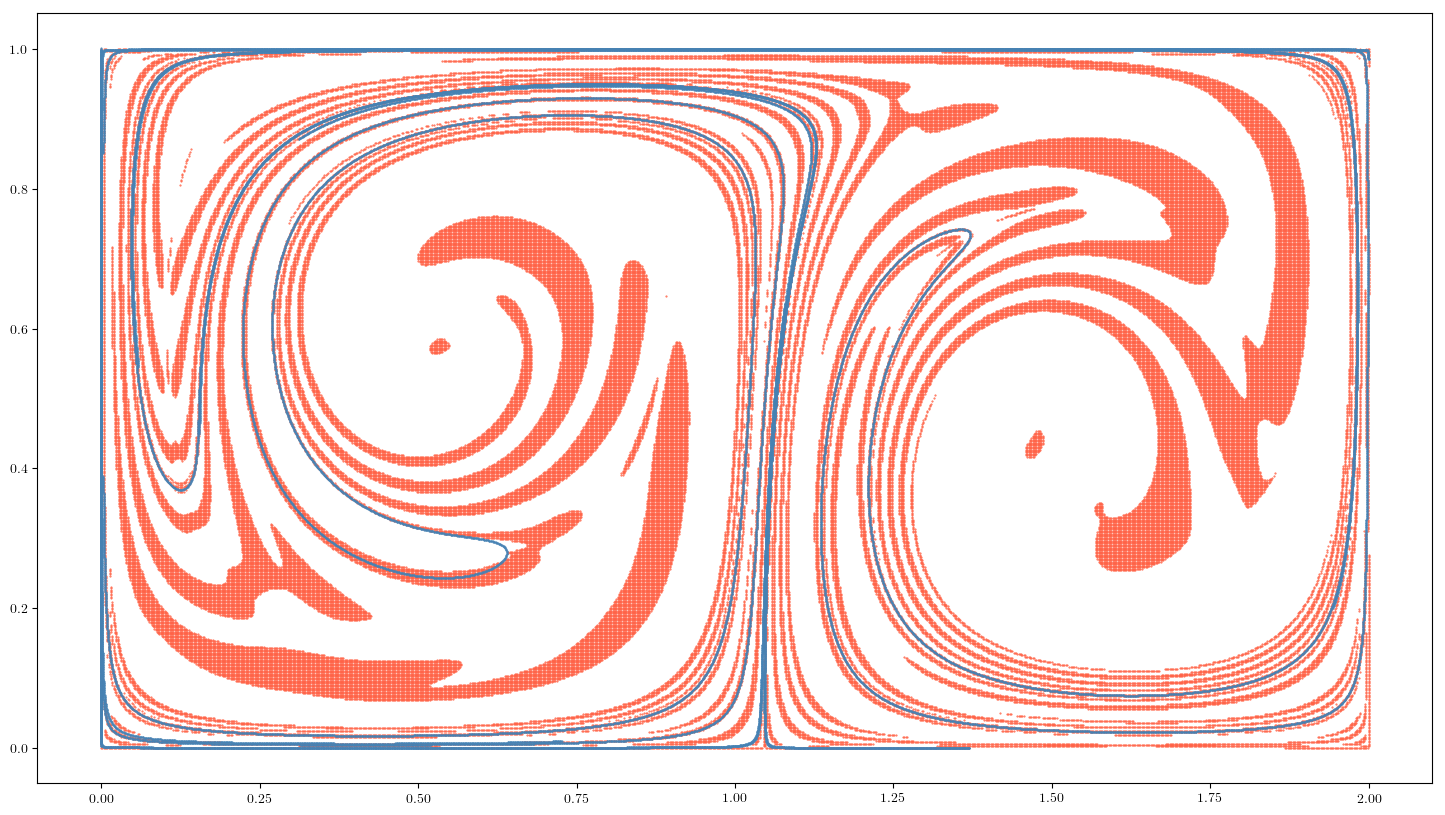

In [1184]:
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],c='tomato',s=1,marker='.')
for LCS in LCSs:
    plt.scatter(LCS.tailcut_traj()[0],LCS.tailcut_traj()[1],c='steelblue',s=1,marker='.')

# Save LCSs

In [567]:
#ensure_path_exists('precomputed_lcs/{}'.format(integrator.__name__))
#if integrator.__name__ in fixed_step_integrators:
#    np.save('precomputed_lcs/{}/lcs_h={}_max_iter={}_stride={}_l_f_max={}_l_min={}_tol_alpha={}.npy'.format(integrator.__name__,h,max_iter,stride,l_f_max,l_min,tol_alpha),LCSs)
#else:
#    np.save('precomputed_lcs/{}/lcs_atol={}_rtol={}_max_iter={}_stride={}_l_f_max={}_l_min={}_tol_alpha={}.npy'.format(integrator.__name__,atol,rtol,max_iter,stride,l_f_max,l_min,tol_alpha),LCSs)

In [568]:
atol

1e-10

In [569]:
LCSs.shape

AttributeError: 'list' object has no attribute 'shape'

In [254]:
q = np.load('precomputed_lcs/{}/lcs_atol={}_rtol={}_max_iter={}_stride={}_l_f_max={}_l_min={}_tol_alpha={}.npy'.format(integrator.__name__,atol,rtol,max_iter,stride,l_f_max,l_min,tol_alpha))

In [260]:
print(help(q[0]))

Help on Strainline in module __main__ object:

class Strainline(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self, startpoint, l_min, l_f_max, lmbd2_spline)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  append(self, pos)
 |  
 |  avg_lmbd2(self)
 |  
 |  lngth(self)
 |  
 |  long_enough(self)
 |  
 |  tailcut_avg_lmbd2(self)
 |  
 |  tailcut_lngth(self)
 |  
 |  tailcut_traj(self)
 |  
 |  traj(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __slotnames__ = []

None


In [225]:
q[0]

IndexError: too many indices for array